<a href="https://colab.research.google.com/github/huberyhub/deep_learning_ait/blob/main/AIT_01_Backprop_NumPy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright

<PRE>
Copyright (c) 2024 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Using this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Solving XOR with backpropagation implemented in NumPy

Historically, XOR is an important step in the development of neural networks. While AND and OR logical operations are possible to be solved with a single perceptrion (referred to as [Rosenblatt perceptron](https://en.wikipedia.org/wiki/Perceptron)), the XOR operation was not solveable by it, as it is not a linearly seperable problem. What does it mean? Let's investigate the truth table of XOR:


  A     | B   | A XOR B
  :----:| :----:|:--------:
  0     | 0   |    0
  1     | 0   |    1
  0     | 1   |    1
  1     | 1   |    0

Plotting the XOR below shows us, that we are unable to draw a single 2-dimension line that separates the two 'output classes' - zero and one. A single perceptron could solve linearly seperable problems only, thus, this was a result that indicated the multi layer perceptron.

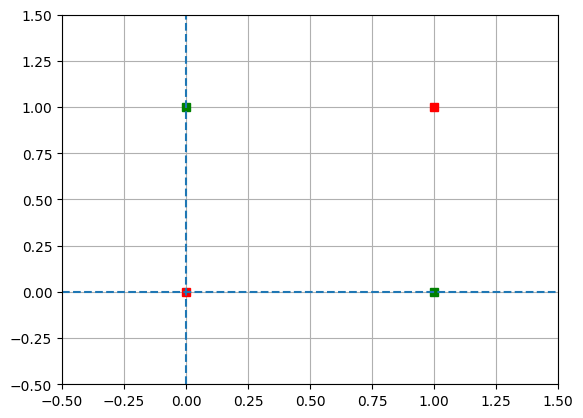

In [ ]:
import matplotlib.pyplot as plt
true_x, true_y =   [1, 0], [0, 1]
false_x, false_y = [0, 1], [0, 1]
plot1 = plt.plot(true_x, true_y,'gs')
plot2 = plt.plot(false_x, false_y, 'rs')
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
plt.grid(True)
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed')
plt.show()

Let's start with imports and data generation. The data in this case will represent XOR with additive noise.

In [ ]:
import numpy as np
from sklearn import preprocessing
import copy

In [ ]:
nb_samples=1000 # number of sample points
X = np.zeros((nb_samples,2)) # two-dimensional input (X1 and X2 coordinates of the points)
Y = np.zeros(nb_samples) # output ('class': 0 or 1)
for i in range(0,nb_samples,4):
    noise = np.random.normal(0,1,8)
    X[i], Y[i] = (-2+noise[0],-2+noise[1]), 0
    X[i+1], Y[i+1] = (2+noise[2],-2+noise[3]), 1
    X[i+2], Y[i+2] = (-2+noise[4],2+noise[5]), 1
    X[i+3], Y[i+3] = (2+noise[6],2+noise[7]), 0

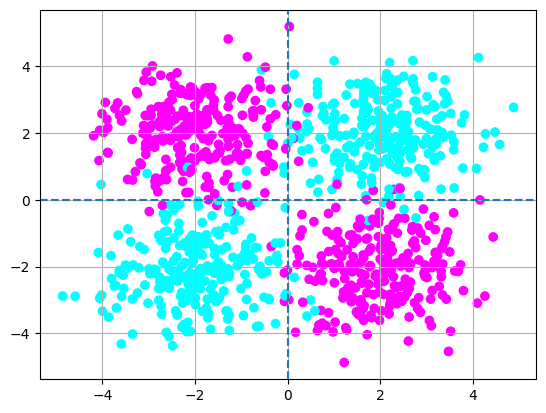

In [ ]:
fig1=plt.figure()
plt.grid(True)
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed')
plt.scatter(X[:,0],X[:,1],c=Y[:], cmap=plt.cm.cool)

Next, we define the activation functions. In every neuron, the sum is followed by an activation fuction, which can be e.g. sigmoid, tanh, relu, etc. This time we use sigmoid.

In [ ]:
def activation(x):
    return 1 / (1 + np.exp(-x))

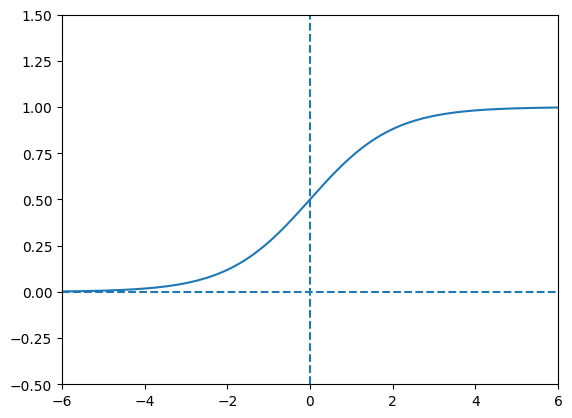

In [ ]:
dummyX=np.linspace(-6,6,200)
plt.xlim(-6, 6)
plt.ylim(-0.5, 1.5)
plt.axhline(0, linestyle='dashed')
plt.axvline(0, linestyle='dashed')
plt.plot(dummyX,activation(dummyX))

We will also need the derivative of the activation function. In this case we use the derivative of sigmoid:

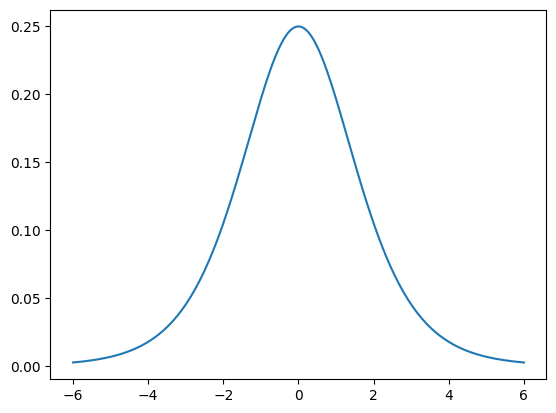

In [ ]:
def dactivation(x):
    return np.exp(-x)/((1+np.exp(-x))**2)

dummyX=np.linspace(-6,6,200)
plt.plot(dummyX,dactivation(dummyX))

Next, we define the multi layer perceptron (a.k.a. neural network, or deep neural network, if we have more than one layer) in a [Python class](https://docs.python.org/3/tutorial/classes.html):

In [ ]:
class MLP:
    # Constructor of the class. The args defines the layers of the neural network
    # E.g. 2,10,10,1 means
    #               - two-dimensional input
    #               - 10 neurons in the first hidden layer
    #               - 10 neurons in the second hidden layer
    #               - 1 neuron in the output layer, i.e. one-dimensional output

    def __init__(self, *args):
        np.random.seed(123)     # random seed for reproducibility
        self.shape  = args      # shape of the network
        n           = len(args) # number of layers
        self.layers = []        # activations of the layers

        # the activation of the first layer is the data itself + a bias
        self.layers.append(np.ones(self.shape[0]+1))
        # hidden and output layers
        for i in range(1,n):
            self.layers.append(np.ones(self.shape[i]))

        # defining weight matrices
        self.weights = []
        for i in range(n-1):
            self.weights.append(np.zeros((self.layers[i].size,self.layers[i+1].size)))

        # needed for later use of momentum method
        self.dw = [0,]*len(self.weights)

        # weight initialization
        self.reset()

    def reset(self):
        for i in range(len(self.weights)):
            # generate a random number in [0,1)
            Z = np.random.random((self.layers[i].size,self.layers[i+1].size))
            # scaling the weight values
            self.weights[i] = (2*Z-1)*np.sqrt(self.layers[i].size)

    # Forward propagation
    def propagate_forward(self, data):
        # feed the data to the input layer
        self.layers[0][0:-1] = data
        # propagate forward and activate after each layer
        for i in range(1,len(self.shape)):
            self.layers[i] = activation(np.dot(self.layers[i-1],self.weights[i-1]))
        # return the predictions
        return self.layers[-1]

    # backward propagation
    def propagate_backward(self, target, lrate=0.1):
        # here we will store the gradients
        deltas = []
        # calculating the derivative of mean squarred error
        error = -(target-self.layers[-1])
        # backpropagating from the output
        delta = error*dactivation(np.dot(self.layers[-2],self.weights[-1]))
        # calculating gradients layer by layer (backwards) with the chain rule
        deltas.append(delta)
        for i in range(len(self.shape)-2,0,-1):
            delta = np.dot(deltas[0],self.weights[i].T)*dactivation(np.dot(self.layers[i-1],self.weights[i-1]))
            deltas.insert(0,delta)

        # updating the weights
        for i in range(len(self.weights)):
            layer = np.atleast_2d(self.layers[i])
            delta = np.atleast_2d(deltas[i])
            dw    = -lrate*np.dot(layer.T,delta)
            self.weights[i] += dw

        # return the error
        return (error**2).sum()

In [ ]:
def learn(model, X, Y, valid_split, test_split, epochs=20, lrate=0.1, momentum=0.9, patience=10):
        # Train-validation-test split
        v_split = int(nb_samples*(1-valid_split-test_split))
        t_split = int(nb_samples*(1-test_split))
        X_train = X[0:v_split]
        Y_train = Y[0:v_split]
        X_valid = X[v_split:t_split]
        Y_valid = Y[v_split:t_split]
        X_test  = X[t_split:]
        Y_test  = Y[t_split:]

        # Standardize
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_valid = scaler.transform(X_valid)
        X_test  = scaler.transform(X_test)

        # Shuffling input training data
        randperm = np.random.permutation(len(X_train))
        X_train, Y_train = X_train[randperm], Y_train[randperm]

        # Training loop for epochs times
        for i in range(epochs):
            # Training phase - sample by sample
            train_err = 0
            for k in range(X_train.shape[0]):
                model.propagate_forward( X_train[k] )
                train_err += model.propagate_backward( Y_train[k], lrate )
            train_err /= X_train.shape[0]

            # Validation phase
            valid_err = 0
            o_valid = np.zeros(X_valid.shape[0])
            for k in range(X_valid.shape[0]):
                o_valid[k] = model.propagate_forward(X_valid[k])
                valid_err += (o_valid[k]-Y_valid[k])**2
            valid_err /= X_valid.shape[0]

            print("%d epoch, train_err: %.4f, valid_err: %.4f" % (i, train_err, valid_err))

        # Test phase
        print("\n--- Testing ---\n")
        test_err = 0
        o_test = np.zeros(X_test.shape[0])
        for k in range(X_test.shape[0]):
            o_test[k] = model.propagate_forward(X_test[k])
            test_err += (o_test[k]-Y_test[k])**2
            print(k, X_test[k], '%.2f' % o_test[k], ' (groundtruth: %.2f)' % Y_test[k])
        test_err /= X_test.shape[0]

        print("test_err: %.4f" % (test_err))

        # plotting figure
        fig1=plt.figure()
        plt.scatter(X_test[:,0], X_test[:,1], c=np.round(o_test[:]), cmap=plt.cm.cool)

In [ ]:
# creating the neural network
model = MLP(2,10,1)

0 epoch, train_err: 0.2919, valid_err: 0.2823
1 epoch, train_err: 0.2828, valid_err: 0.2783
2 epoch, train_err: 0.2777, valid_err: 0.2701
3 epoch, train_err: 0.2448, valid_err: 0.1819
4 epoch, train_err: 0.1576, valid_err: 0.1378
5 epoch, train_err: 0.1233, valid_err: 0.1101
6 epoch, train_err: 0.1020, valid_err: 0.0920
7 epoch, train_err: 0.0882, valid_err: 0.0799
8 epoch, train_err: 0.0789, valid_err: 0.0717
9 epoch, train_err: 0.0724, valid_err: 0.0658
10 epoch, train_err: 0.0675, valid_err: 0.0615
11 epoch, train_err: 0.0639, valid_err: 0.0583
12 epoch, train_err: 0.0610, valid_err: 0.0558
13 epoch, train_err: 0.0587, valid_err: 0.0538
14 epoch, train_err: 0.0567, valid_err: 0.0521
15 epoch, train_err: 0.0550, valid_err: 0.0508
16 epoch, train_err: 0.0535, valid_err: 0.0497
17 epoch, train_err: 0.0522, valid_err: 0.0487
18 epoch, train_err: 0.0510, valid_err: 0.0479
19 epoch, train_err: 0.0498, valid_err: 0.0471

--- Testing ---

0 [-0.50538389 -0.73241604] 0.14  (groundtruth: 0.00

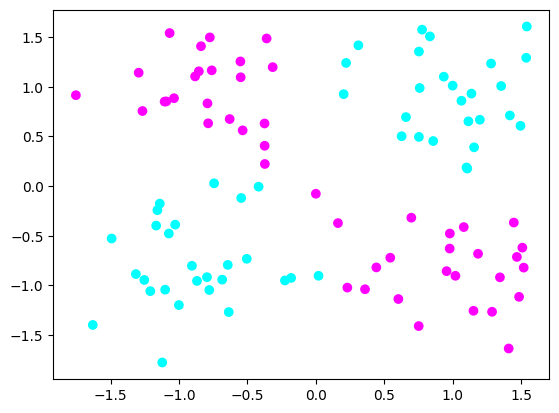

In [ ]:
# Tanítás/Tesztelés indítása
model.reset()
learn(model, X, Y, 0.2, 0.1)

Inspecting weight matrices:

In [ ]:
for i,w in enumerate(model.weights):
  print("{}. weight matrix, shape:".format(i),w.shape)
  print(w)
  print("\n")

0. weight matrix, shape: (3, 10)
[[ 1.04761499  0.39152558  0.72747227  2.22316059  2.90458812 -0.715611
   0.2965303   2.34608635  1.95321329  2.1750252 ]
 [-1.52412895  0.49990327 -0.0950562   1.37686009 -2.89913998 -0.58482247
  -0.44406398  2.91165232  2.52905799 -0.17996497]
 [ 1.61626992 -0.5066559   0.39830046  1.55524627  3.09244852 -1.45447315
   0.70068034 -2.68579178 -2.36669488 -0.22908515]]


1. weight matrix, shape: (10, 1)
[[-1.68326801]
 [ 1.91047615]
 [ 1.42473465]
 [ 3.66121996]
 [-4.64820885]
 [-0.34810245]
 [ 1.37462012]
 [-4.18116726]
 [-3.69264521]
 [ 3.57187809]]


